In [1]:
# Célula 1: Instalação das dependências (se ainda não tiver instalado)
%pip install --user scikit-learn imbalanced-learn pandas seaborn matplotlib pyarrow shap

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.44.0-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 545.1/545.1 kB 4.5 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.61.2-cp313-cp313-win_amd64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp313-cp313-win_amd64.whl (30.3 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)

   ---------------------------------------- 0/8 [tqdm]
   ---------------------------------------- 0/8 [tqdm]
   ---------------------------------------- 0/8 [tqdm]
   ---------------------------------------- 0/8 [tqdm]
   ---

In [2]:
# Célula 2: Importação das bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier # Algoritmo principal desta análise
from sklearn.metrics import (
    accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')


C:\Users\Sintepe\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
df = pd.read_parquet('data/processed/wine-quality.parquet')
print("Colunas do dataset carregado:", df.columns.tolist())

Colunas do dataset carregado: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [10]:
# Target binária (quality > 5 = bom (1), <=5 ruim (0))
df['good_quality'] = (df['quality'] > 5).astype(int)
df.drop('quality', axis=1, inplace=True)

In [11]:
# Encoding da variável 'type'
if df['type'].dtype == 'object':
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])
    print("Coluna 'type' codificada.")
else:
    print("Coluna 'type' já está numérica.")

Coluna 'type' codificada.



Distribuição das classes (good_quality):
good_quality
1    4113
0    2384
Name: count, dtype: int64


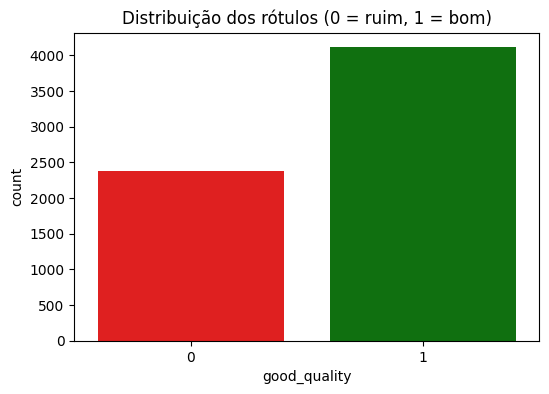

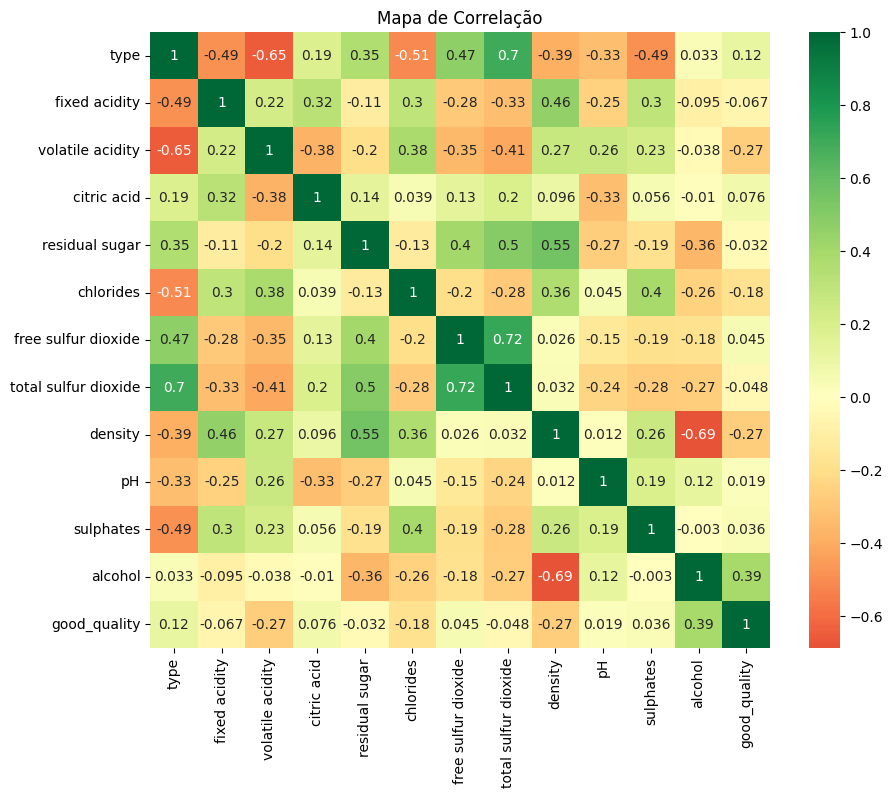

In [12]:
# Análise das classes
print("\nDistribuição das classes (good_quality):")
print(df['good_quality'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='good_quality', hue='good_quality', data=df, palette={0: 'red', 1: 'green'}, legend=False)
plt.title("Distribuição dos rótulos (0 = ruim, 1 = bom)")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', center=0)
plt.title("Mapa de Correlação")
plt.show()

In [13]:
# X = variáveis independentes (características físico-químicas)
# y = variável dependente (qualidade do vinho)
X = df.drop('good_quality', axis=1)
y = df['good_quality']

In [15]:
# Célula 7: Divisão em Conjuntos de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# --- Seção Principal: MLP com Balanceamento SMOTE ---
# A normalização dos dados é CRUCIAL para o bom funcionamento de redes neurais.

print("\n--- INICIANDO TREINAMENTO: MLP (REDE NEURAL) + SMOTE ---")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Aplicando a normalização (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

print(f"Distribuição de classes no treino original: {np.bincount(y_train)}")
print(f"Distribuição de classes após SMOTE: {np.bincount(y_train_smote)}")


--- INICIANDO TREINAMENTO: MLP (REDE NEURAL) + SMOTE ---
Distribuição de classes no treino original: [1907 3290]
Distribuição de classes após SMOTE: [3290 3290]


In [17]:
# Célula 9: Treinamento do Modelo com GridSearchCV
def treinar_mlp_com_grid(X_train, y_train):
    """
    Treina um modelo MLP com busca de hiperparâmetros.
    """
    # Grade de parâmetros para a rede neural
    param_grid = {
        'hidden_layer_sizes': [(50, 50), (100,)], # Testar com 2 camadas de 50 neurônios ou 1 de 100
        'activation': ['relu', 'tanh'], # Funções de ativação a testar
        'solver': ['adam'],
        'alpha': [0.0001, 0.001], # Parâmetro de regularização L2
        'learning_rate': ['constant', 'adaptive'],
    }
    
    mlp = MLPClassifier(random_state=42, max_iter=300) # Aumentar max_iter para garantir convergência
    
    grid = GridSearchCV(
        estimator=mlp,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=3),
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

best_mlp, best_params = treinar_mlp_com_grid(X_train_scaled, y_train_smote)
print("\nMelhores parâmetros encontrados (MLP + SMOTE):", best_params)


Fitting 3 folds for each of 16 candidates, totalling 48 fits

Melhores parâmetros encontrados (MLP + SMOTE): {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [18]:
# Célula 10: Avaliação de Performance
y_pred = best_mlp.predict(X_test_scaled)
acc_test = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n===== Relatório de Classificação (MLP + SMOTE) =====")
print(report)
print(f"Acurácia final no Conjunto de Teste: {acc_test:.4f}")



===== Relatório de Classificação (MLP + SMOTE) =====
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       477
           1       0.84      0.78      0.81       823

    accuracy                           0.76      1300
   macro avg       0.75      0.76      0.75      1300
weighted avg       0.77      0.76      0.77      1300

Acurácia final no Conjunto de Teste: 0.7646



--- Gerando Matriz de Confusão ---


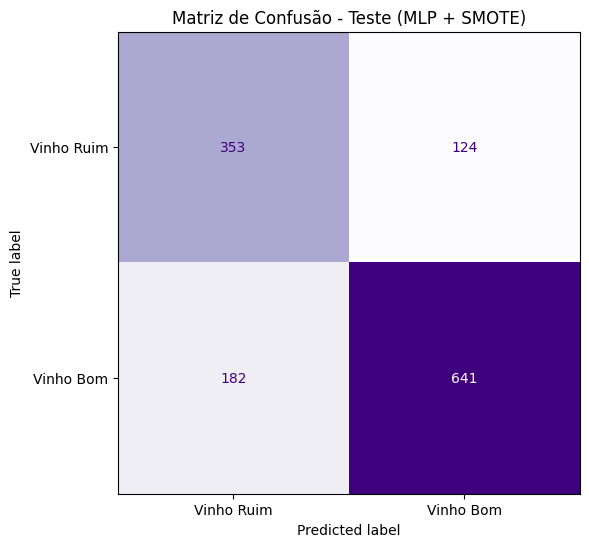

In [20]:
# Célula 11: Matriz de Confusão (com nomes das classes)
print("\n--- Gerando Matriz de Confusão ---")

# Define os nomes das classes que queremos exibir
display_labels = ['Vinho Ruim', 'Vinho Bom']

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    best_mlp,
    X_test_scaled,
    y_test,
    ax=ax,
    cmap='Purples', # Paleta de cores roxas
    colorbar=False,
    display_labels=display_labels # Adicionado para mostrar os nomes
)
ax.set_title("Matriz de Confusão - Teste (MLP + SMOTE)")
plt.savefig("confusion_matrix_mlp_named.png")
plt.show()


--- Analisando importância das features com SHAP (pode levar alguns minutos) ---


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


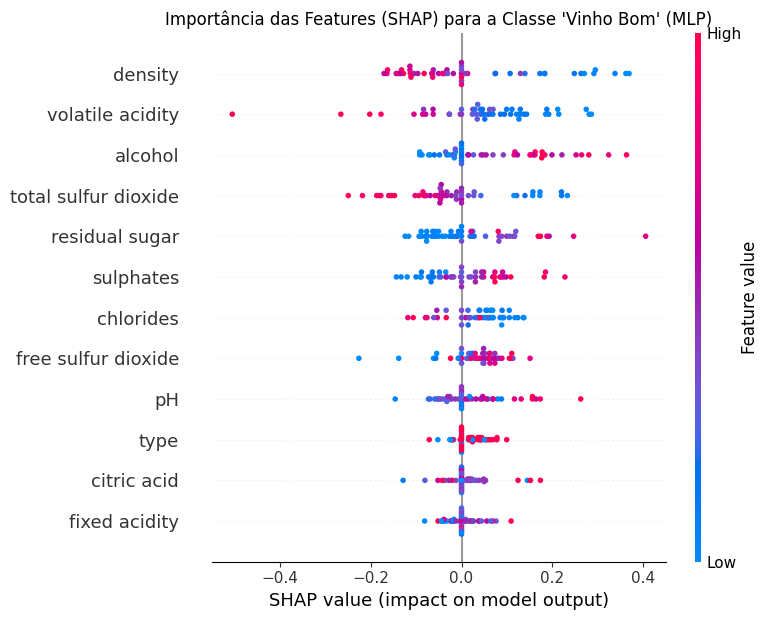

In [23]:
# Célula 12: Análise de Features com SHAP
# Para MLP (modelo de caixa-preta), usamos o KernelExplainer.
# AVISO: Este processo pode ser LENTO, pois precisa de muitas predições para estimar os valores SHAP.
print("\n--- Analisando importância das features com SHAP (pode levar alguns minutos) ---")

# Para acelerar, usamos um subconjunto dos dados para criar o explainer
# Usando 100 amostras do treino para o fundo e 50 do teste para explicar
X_train_shap_sample = shap.sample(X_train_scaled, 100)
X_test_shap_sample = shap.sample(X_test_scaled, 50)

# Criamos o explainer com a função de predição de probabilidade do modelo
explainer = shap.KernelExplainer(best_mlp.predict_proba, X_train_shap_sample)
shap_values = explainer.shap_values(X_test_shap_sample)

# Plotar o resumo para a classe "Vinho Bom" (classe 1)
# Ajuste para multiclass: shap_values tem shape (samples, features, classes)
shap_values_class1 = shap_values[:, :, 1]
assert shap_values_class1.shape == X_test_shap_sample.shape, (
	f"Shape mismatch: shap_values_class1 {shap_values_class1.shape} vs X_test_shap_sample {X_test_shap_sample.shape}"
)
shap.summary_plot(shap_values_class1, X_test_shap_sample, feature_names=X.columns, show=False)
plt.title("Importância das Features (SHAP) para a Classe 'Vinho Bom' (MLP)")
plt.tight_layout()
plt.savefig("shap_summary_mlp.png")
plt.show()